In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import zipfile
import shutil 
from tqdm import tqdm

In [2]:
IS_KAGGLE_ENV = False   # False when local environment
BACKBONE_SIZE = 'large' # in ('small', 'base', 'large' or 'giant')
DATA_ROOT, NUM_WORKERS = ('/kaggle/working', 4) if IS_KAGGLE_ENV else ('../data/plates', 0)
OUTPUT_DIR = 'output'
TRAIN_DIR = 'train'
VAL_DIR = 'val'
TEST_DIR = 'test'
CROP_SIZE = 224
BATCH_SIZE = 8
NUM_LAYERS = 4   # 4 for ViTS
EPOCHS = 50
VAL_FREQ = 1

In [3]:
def create_dir_structure(is_kaggle=IS_KAGGLE_ENV):
    if is_kaggle:
        # Input data files are available in the "../input/" directory.
        print(os.listdir("../input"))

        with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
        # Extract all the contents of zip file in current directory
            zip_obj.extractall(DATA_ROOT)
            
        print('After zip extraction:')
        print(os.listdir(DATA_ROOT))

        from_dir = os.path.join(DATA_ROOT, 'plates')

        class_names = ['cleaned', 'dirty']

        for dir_name in [TRAIN_DIR, VAL_DIR]:
            for class_name in class_names:
                os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

        for class_name in class_names:
            source_dir = os.path.join(from_dir, 'train', class_name)
            for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
                if i % 6 != 0:
                    dest_dir = os.path.join(TRAIN_DIR, class_name) 
                else:
                    dest_dir = os.path.join(VAL_DIR, class_name)
                shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
        
        shutil.copytree(os.path.join(from_dir, 'test'), TEST_DIR, dirs_exist_ok=True)
        print(os.listdir(DATA_ROOT))
    
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
create_dir_structure()

In [4]:
import time
import copy
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import v2

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
print(f'torch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')

Device: cpu
torch version: 2.1.0
torchvision version: 0.16.0


In [6]:
def fix_random_seeds(seed=12345):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
fix_random_seeds()

In [7]:
# Class for test dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path: Path, tfms: v2.Compose):
        self.path = path
        self.tfms = tfms
        self.filenames = list(path.glob("*.jpg"))
        
    def __getitem__(self, index):
        filename = self.filenames[index]
        img = read_image(str(filename))
        img = self.tfms(img)
        return img, filename.stem
        
    def __len__(self):
        return len(self.filenames)

In [8]:
data_transforms = {
    'train': v2.Compose([
        v2.PILToTensor(),
        # v2.CenterCrop(CROP_SIZE),
        # v2.RandomResizedCrop(size=CROP_SIZE, scale=(0.4, 0.875), ratio=(0.75, 1.25), interpolation=v2.InterpolationMode.BICUBIC, antialias=True),
        v2.RandomResizedCrop(size=CROP_SIZE, interpolation=v2.InterpolationMode.BICUBIC, antialias=True),
        v2.RandomHorizontalFlip(p=0.5),
        # v2.AutoAugment(v2.AutoAugmentPolicy.IMAGENET),
        v2.ConvertImageDtype(torch.float32),
        # v2.ToTensor(),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]),
    'val': v2.Compose([
        v2.PILToTensor(),
        v2.CenterCrop(CROP_SIZE),
        v2.ConvertImageDtype(torch.float32),
        # v2.ToTensor(),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]),
    'test': v2.Compose([
        v2.PILToTensor(),
        v2.CenterCrop(CROP_SIZE),
        v2.ConvertImageDtype(torch.float32),
        # v2.ToTensor(),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_ROOT, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=NUM_WORKERS)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Data loaded with {dataset_sizes['train']} train and {dataset_sizes['val']} val images.")

Data loaded with 32 train and 8 val images.


In [9]:
image_datasets['test'] = CustomDataset(Path(os.path.join(DATA_ROOT, 'test')), data_transforms['test'])

dataloaders['test'] = torch.utils.data.DataLoader(
    image_datasets['test'],
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

dataset_sizes['test'] = len(image_datasets['test'])
print(f"Data loaded with {dataset_sizes['test']} test images.")

Data loaded with 744 test images.


In [10]:
def show_batch(imgs, titles=None, rows=2, cols=4):
    if titles is None:
        titles = [ 'image ' + str(i+1) for i in range(imgs.size(0))]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    fig = plt.figure(figsize=(cols * 3, rows * 3))
    for i in range(imgs.size(0)):
        img = imgs[i].cpu().numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.set_title(titles[i])
        ax.axis('off')
    fig.tight_layout()

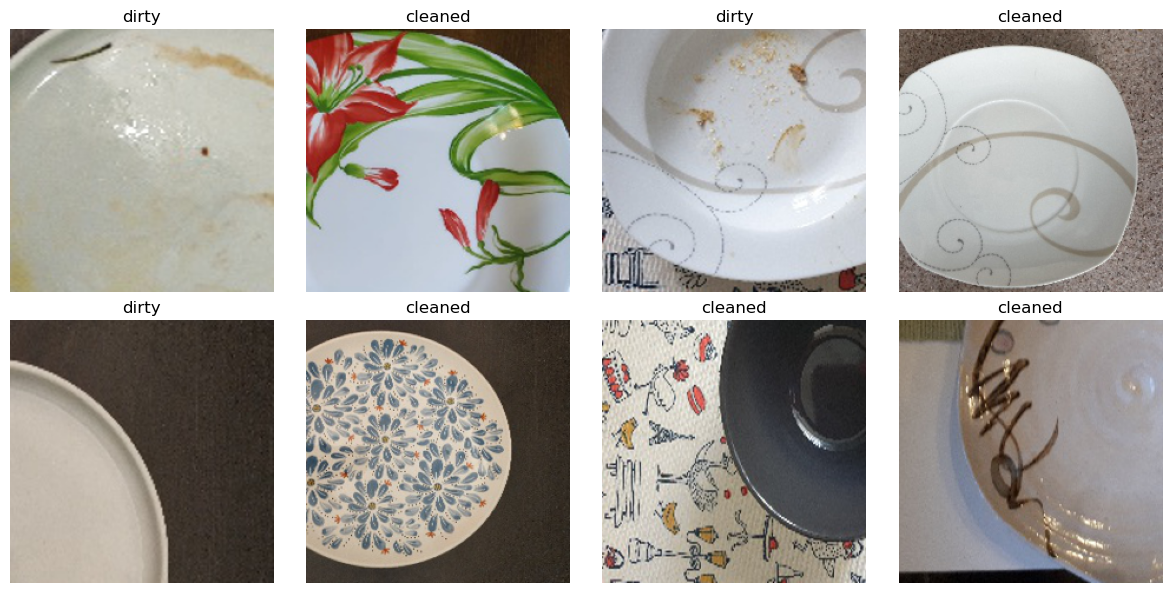

In [11]:
inputs, classes = next(iter(dataloaders['train']))
show_batch(inputs, titles=[class_names[x] for x in classes])

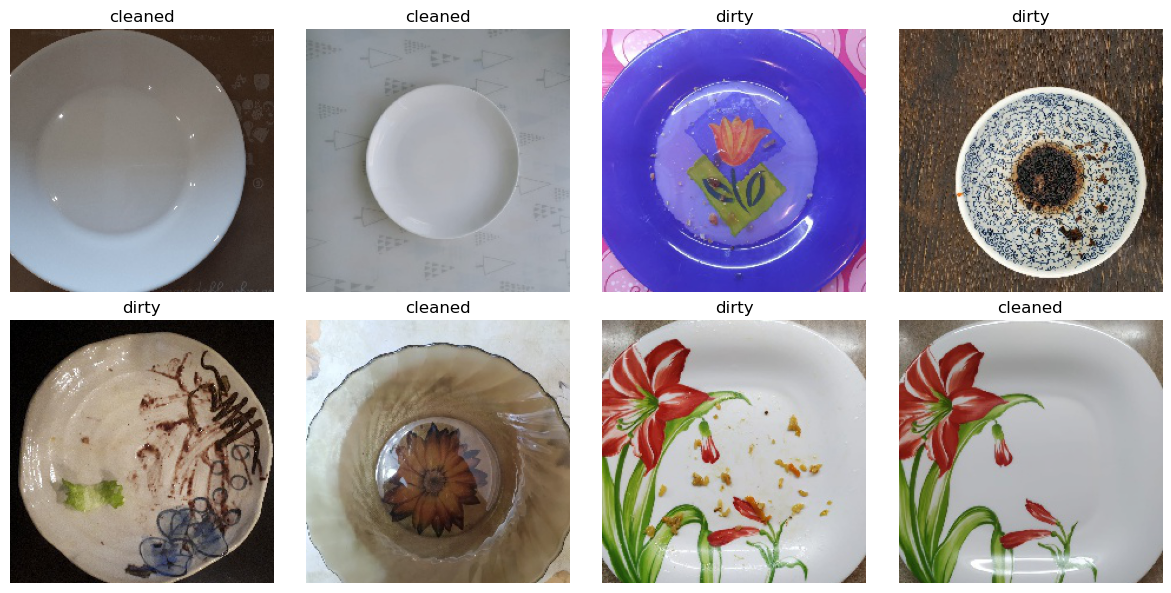

In [12]:
inputs, classes = next(iter(dataloaders['val']))
show_batch(inputs, titles=[class_names[x] for x in classes])

In [13]:
class LinearClassifier(nn.Module):
    """Linear layer to train on top of frozen features"""
    def __init__(self, dim, num_labels=2):
        super(LinearClassifier, self).__init__()
        self.num_labels = num_labels
        self.linear = nn.Linear(dim, num_labels)
        self.linear.weight.data.normal_(mean=0.0, std=0.01)
        self.linear.bias.data.zero_()

    def forward(self, x):
        # flatten
        x = x.view(x.size(0), -1)

        # linear layer
        return self.linear(x)

In [14]:
def extract_features(model, batch, num_layers=NUM_LAYERS):
    with torch.no_grad():
        intermediate_output = model.get_intermediate_layers(batch, num_layers, return_class_token=True)
        features = torch.cat([class_token for _, class_token in intermediate_output], dim=-1) 
        # features = torch.cat([x[1] for x in intermediate_output], dim=-1)   
    return features

In [15]:
def train_loop(dataloader, model, linear_classifier, loss_fn, optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    linear_classifier.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_loss = 0.0
    running_corrects = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        features = extract_features(model, X)
        # Compute prediction and loss
        pred = linear_classifier(features)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Statistics
        running_loss += loss.item()
        running_corrects += (pred.argmax(1) == y).type(torch.float).sum().item()

    epoch_loss = running_loss / num_batches
    epoch_acc  = running_corrects / size
    return epoch_acc, epoch_loss

In [16]:
def val_loop(dataloader, model, linear_classifier, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    linear_classifier.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, val_acc = 0.0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)   
            features = extract_features(model, X) 
            pred = linear_classifier(features)
            val_loss += loss_fn(pred, y).item()
            val_acc += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    val_acc  /= size
    return val_acc, val_loss

In [17]:


backbone_archs = {
    'small': 'vits14',
    'base': 'vitb14',
    'large': 'vitl14',
    'giant': 'vitg14',
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f'dinov2_{backbone_arch}'

backbone_model = torch.hub.load(repo_or_dir='facebookresearch/dinov2', model=backbone_name)
backbone_model = backbone_model.to(device)

Using cache found in /Users/maxim/.cache/torch/hub/facebookresearch_dinov2_main
/Users/maxim/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/maxim/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/maxim/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [18]:
embed_dim = backbone_model.embed_dim * NUM_LAYERS
linear_classifier = LinearClassifier(embed_dim)
linear_classifier = linear_classifier.to(device)

loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(linear_classifier.parameters(), lr=0.0003, betas=(0.9, 0.999))
optimizer = torch.optim.SGD(
    linear_classifier.parameters(),
    lr=0.0005,
    momentum=0.9,
    weight_decay=0, # we do not apply weight decay
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=0)

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
best_acc = 0.0
best_acc_loss = 1.0
train_data = []
for t in range(EPOCHS):
    print(f'Epoch {t+1}\n-------------------------------')

    train_acc, train_loss = train_loop(dataloaders['train'], backbone_model, linear_classifier, loss_fn, optimizer)
    # print(f'lr = {optimizer.param_groups[0]["lr"]}')
    train_data.append({
        'phase': 'train',
        'epoch': t,
        'lr': optimizer.param_groups[0]["lr"],
        'accuracy': train_acc,
        'loss': train_loss
    })
    scheduler.step()
    print(f'Train:\n  train_acc = {train_acc}, train_loss = {train_loss}')
    if t % VAL_FREQ == 0 or t == EPOCHS - 1:
        val_acc, val_loss = val_loop(dataloaders['val'], backbone_model, linear_classifier, loss_fn)
        train_data.append({
            'phase': 'val',
            'epoch': t,
            'lr': optimizer.param_groups[0]["lr"],
            'accuracy': val_acc,
            'loss': val_loss
        })
        print(f'Validation:\n     val_acc = {val_acc}, val_loss = {val_loss}')
        if val_acc >= best_acc and val_loss < best_acc_loss:
            best_acc, best_acc_loss = val_acc, val_loss
            print(f'Best accuracy = {best_acc}, best_loss = {best_acc_loss}')
            save_dict = {
                'epoch': t + 1,
                'state_dict': linear_classifier.state_dict(),
                'optimizer': optimizer.state_dict(),
                # 'scheduler': scheduler.state_dict(),
                'best_acc': best_acc,
                'best_loss': best_acc_loss
            }
            torch.save(save_dict, os.path.join(OUTPUT_DIR, 'dino_classifier_ckpt.pth'))
    print('\n')
print('Training completed.')



Epoch 1
-------------------------------
Train:
  train_acc = 0.71875, train_loss = 0.5792712643742561
Validation:
     val_acc = 0.75, val_loss = 0.4196837544441223
Best accuracy = 0.75, best_loss = 0.4196837544441223


Epoch 2
-------------------------------
Train:
  train_acc = 0.90625, train_loss = 0.32647694647312164
Validation:
     val_acc = 0.875, val_loss = 0.39224228262901306
Best accuracy = 0.875, best_loss = 0.39224228262901306


Epoch 3
-------------------------------
Train:
  train_acc = 1.0, train_loss = 0.15673253126442432
Validation:
     val_acc = 0.875, val_loss = 0.1569451242685318
Best accuracy = 0.875, best_loss = 0.1569451242685318


Epoch 4
-------------------------------
Train:
  train_acc = 0.96875, train_loss = 0.11085500381886959
Validation:
     val_acc = 0.875, val_loss = 0.20921173691749573


Epoch 5
-------------------------------
Train:
  train_acc = 0.96875, train_loss = 0.1258635837584734
Validation:
     val_acc = 0.875, val_loss = 0.21274332702159882

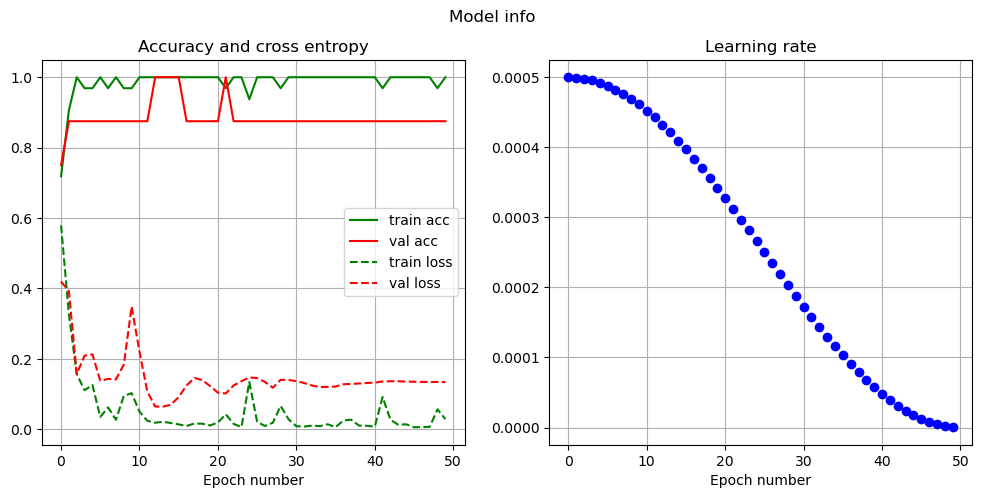

In [19]:
train_df = pd.DataFrame(train_data)
train_phase = train_df[train_df['phase'] == 'train']
val_phase   = train_df[train_df['phase'] == 'val']
y_axis = 'accuracy'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
line_acc_train, = ax1.plot(train_phase['epoch'], train_phase['accuracy'], 'g-', label='train acc')
line_acc_val, = ax1.plot(val_phase['epoch'], val_phase['accuracy'], 'r-', label='val acc')
line_loss_train, = ax1.plot(train_phase['epoch'], train_phase['loss'], 'g--', label='train loss')
line_loss_val, = ax1.plot(val_phase['epoch'], val_phase['loss'], 'r--', label='val loss')
ax1.set_xlabel('Epoch number')
ax1.legend(loc='center right')
ax1.set_title('Accuracy and cross entropy')
ax1.grid(visible=True)
line_lr = ax2.plot(train_phase['epoch'], train_phase['lr'], 'ob', label='learning rate')
ax2.set_xlabel('Epoch number')
ax2.set_title('Learning rate')
ax2.grid(visible=True)
fig.suptitle('Model info')
plt.show();

In [20]:
checkpoint = torch.load(os.path.join(OUTPUT_DIR, 'dino_classifier_ckpt.pth'))
epoch = checkpoint['epoch']
best_acc = checkpoint['best_acc']
best_loss = checkpoint['best_loss']
print(epoch, best_acc, best_loss)

14 1.0 0.06446068733930588


In [21]:
model_inf = LinearClassifier(embed_dim)
model_inf = model_inf.to(device)

model_inf.load_state_dict(checkpoint['state_dict'])
model_inf.eval()


LinearClassifier(
  (linear): Linear(in_features=4096, out_features=2, bias=True)
)

In [22]:
def visualize_model(model, linear_classifier, images, rows=2, cols=4):
  was_training = linear_classifier.training
  linear_classifier.eval()

  with torch.no_grad():
    imgs = images.to(device)
    features = extract_features(model, imgs)
    outputs = linear_classifier(features)
    outputs = nn.functional.softmax(outputs, dim=1)
    prediction_score, pred_label_idx = torch.topk(outputs, 1)
    _, preds = torch.max(outputs, 1)
    titles = [f'{class_names[pred_label_idx[i]]}: score {prediction_score[i].squeeze().item():.3f}' for i in range(imgs.size(0))]
    show_batch(imgs, titles=titles)
    
  linear_classifier.train(mode=was_training)


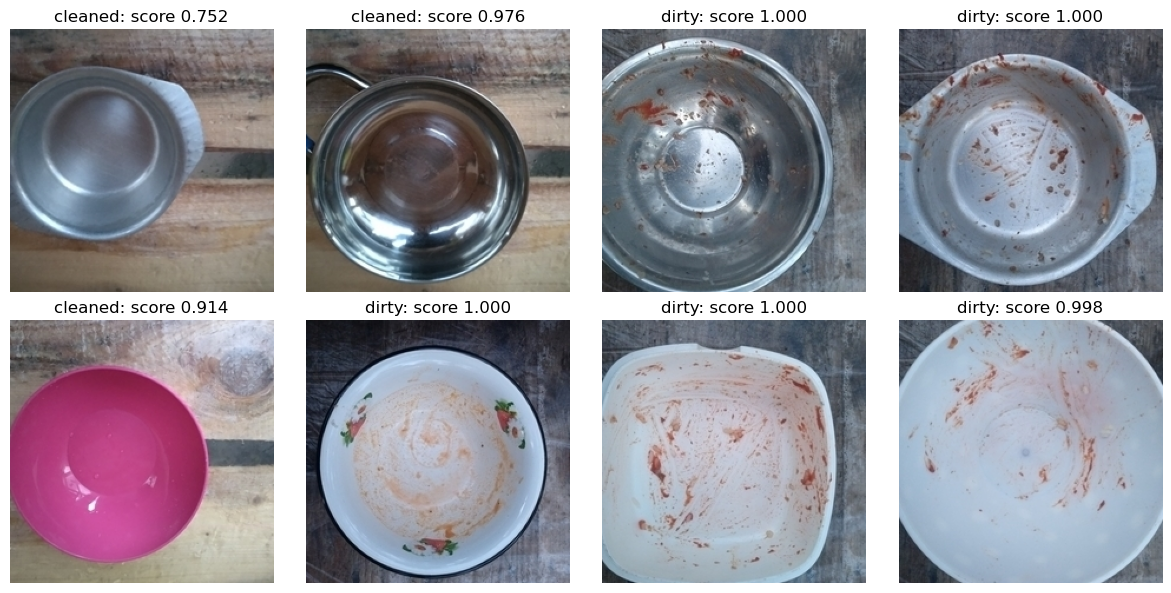

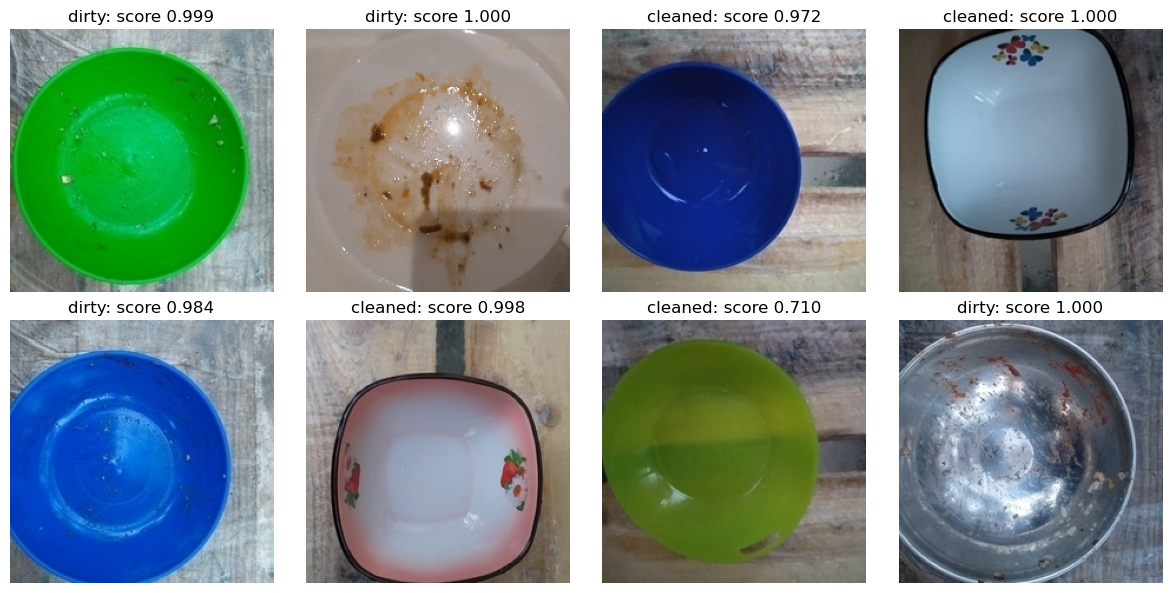

In [23]:
dl_iter = iter(dataloaders['test'])
for _ in range(2):
    imgs, _ = next(dl_iter)
    visualize_model(backbone_model, model_inf, imgs)

In [24]:
test_predictions = []
test_img_paths = []
for inputs, paths in tqdm(dataloaders['test']):
    inputs = inputs.to(device)
    with torch.set_grad_enabled(False):
        features = extract_features(backbone_model, inputs)
        preds = model_inf(features)
    test_predictions.append(
        nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

  0%|          | 0/93 [00:00<?, ?it/s]

100%|██████████| 93/93 [09:20<00:00,  6.03s/it]


In [32]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(8)

label
id           
0071  cleaned
0717  cleaned
0703    dirty
0065    dirty
0059  cleaned
0515    dirty
0273    dirty
0267    dirty

In [33]:
submission_df.to_csv('submission.csv')

In [28]:
# !rm -rf train val test output plates


    @misc{platesv2,
        author = {Igor.Slinko},
        title = {Cleaned vs Dirty V2},
        publisher = {Kaggle},
        year = {2019},
        url = {https://kaggle.com/competitions/platesv2}
    }
